In [2]:
from qiskit import *
from qiskit.visualization import plot_histogram

In [3]:
circ = QuantumCircuit(2,2)

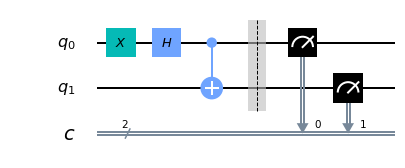

In [4]:
circ.x(0)
circ.h(0)
circ.cx(0,1)
circ.barrier()
circ.measure([0,1],[0,1])
circ.draw(output='mpl')

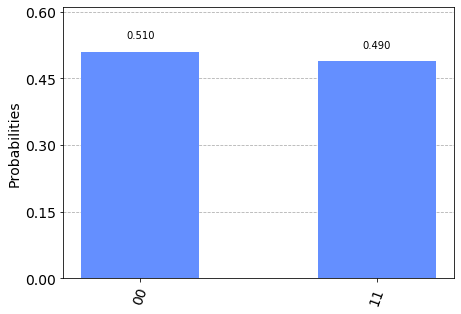

In [5]:
sim = Aer.get_backend('qasm_simulator')
res = execute(circ, backend = sim, shots = 2048).result()
plot_histogram(res.get_counts(circ))

In [6]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_qasm_simulator')
job = execute(circ, backend=qcomp)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

/home/nico/.local/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


Job Status: job has successfully run


The run counts are: {'00': 1044, '11': 1004}


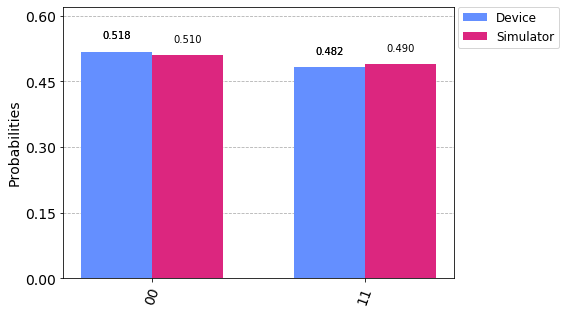

In [10]:
qres = job.result()
counts = res.get_counts()
print('The run counts are:', counts)
plot_histogram([qres.get_counts(circ), res.get_counts(circ)], legend=['Device', 'Simulator'])

Job Status: job has successfully run


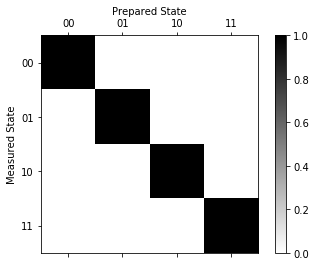

In [11]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

cal_circuits, state_labels = complete_meas_cal(qr=circ.qregs[0], circlabel='measerrormitcal')
cal_job = execute(cal_circuits,
                 backend = qcomp,
                 shots = 1024,
                 optimization_level = 0,
                 )

#this part runs the predefined calibration circuits for the circuit size and monitors the job
job_monitor(cal_job)
calres = cal_job.result()

#we use the calibration result to filter out our noisy results
meas_fitter = CompleteMeasFitter(calres, state_labels)

#filtering out noise from the quantum result
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
mitres = meas_filter.apply(qres)

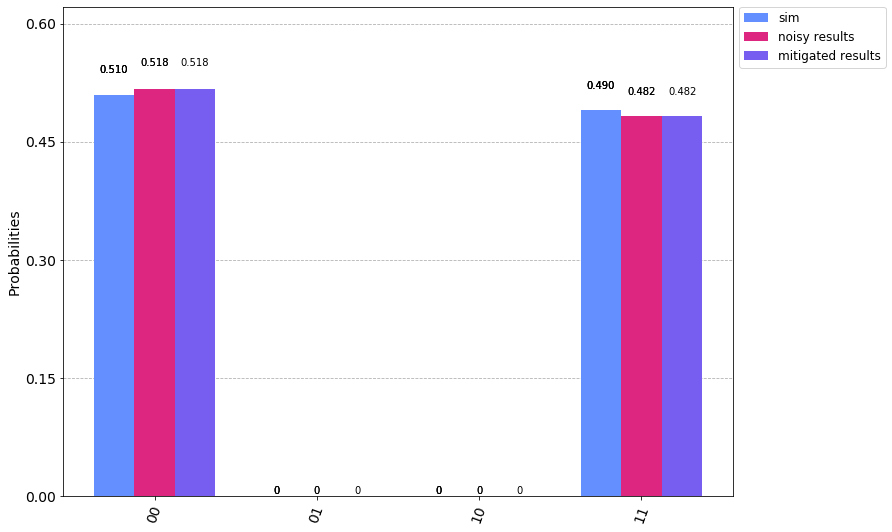

In [12]:
qcounts = qres.get_counts(circ)
mitcounts = mitres.get_counts(circ)
plot_histogram([counts, qcounts, mitcounts], legend = ['sim', 'noisy results', 'mitigated results'], figsize=(12, 9))